# Using PyTorch

## Set Up

In [1]:
import torch
import torch.nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from IPython.display import clear_output
import time
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


c:\Users\Usuario\anaconda3\envs\synthetic\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, ), (0.5, ))
])

dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:14<00:00, 699kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 204kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.26MB/s]


## Visualize some samples

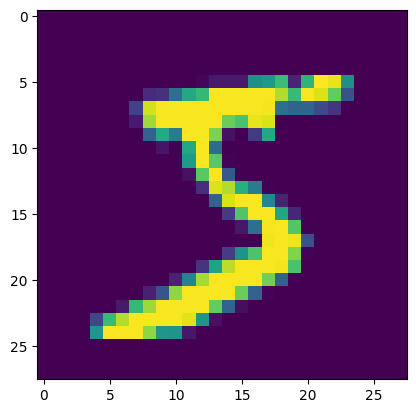

In [4]:
plt.imshow(dataset[0][0].squeeze());

Input shape: torch.Size([64, 1, 28, 28])
Labels: tensor([4, 9, 5, 3, 9, 7, 5, 3, 9, 7, 5, 4, 4, 3, 7, 0, 2, 0, 7, 8, 8, 1, 1, 2,
        0, 0, 2, 2, 4, 0, 3, 0, 5, 9, 1, 5, 3, 4, 7, 6, 6, 7, 8, 2, 3, 4, 9, 8,
        1, 9, 7, 0, 7, 0, 9, 9, 6, 6, 6, 5, 6, 7, 6, 3])


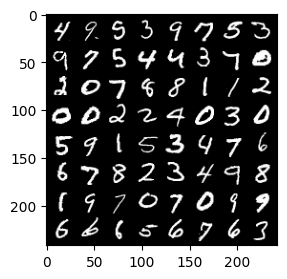

In [5]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)

plt.figure(figsize=(10, 3))
plt.imshow(torchvision.utils.make_grid(x*0.5 + 0.5).permute(1, 2, 0).numpy())
plt.show()

## Forward Diffusion Process

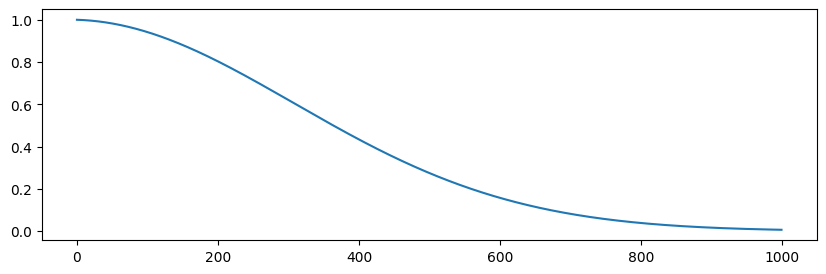

In [6]:
T = 1000
betas = torch.linspace(1e-4, 0.01, T)
alphas = 1-betas
alpha_bars = torch.cumprod(alphas, dim=0)

plt.figure(figsize=(10, 3))
plt.plot(alpha_bars)
plt.show()

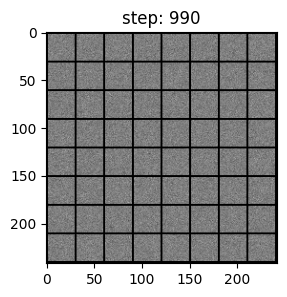

In [9]:
# Start the forward diffusion process

x = x.to(device)

for t in range(T):
    noise = torch.randn_like(x).to(device)

    alpha_bar = alpha_bars[t]
    x_t1 = torch.sqrt(alpha_bar)*x + torch.sqrt(1-alpha_bar)*noise

    if t%10 == 0:
        plt.figure(figsize=(10, 3))
        plt.title(f"step: {t}")
        plt.imshow(torchvision.utils.make_grid(x_t1*0.05 + 0.5).permute(1, 2, 0).cpu().numpy())
        clear_output(wait=True)
        plt.show()

## Create A U-net

In [13]:
import torch
import torch.nn as nn

class MyUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        # ---- Down layers ----
        self.down_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.GroupNorm(1, 32),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.GroupNorm(1, 64),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.GroupNorm(1, 64),
                nn.SiLU()
            ),
        ])
        
        # ---- Up layers ----
        self.up_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.GroupNorm(1, 64),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.GroupNorm(1, 32),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
                # Output layer - no normalization, no activation
            ),
        ])
        
        # ---- Embedding layers ----
        self.time_embedding_layer = nn.Sequential(
            nn.Linear(1, 64),
            nn.LayerNorm(64),
            nn.SiLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32)
        )

        self.class_embedding_layer = nn.Sequential(
            nn.Linear(1, 64),
            nn.LayerNorm(64),
            nn.SiLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32)
        )

        # ---- Scaling operators ----
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, t, cls):
        t = t.reshape(-1, 1).to(x.device)
        cls = cls.reshape(-1, 1).to(x.device)
        
        # Embedding
        t_embd = self.time_embedding_layer(t.float())
        cls_embd = self.class_embedding_layer(cls.float())
        
        # Downsampling path
        h = []
        for i, layer in enumerate(self.down_layers):
            x = layer(x)
            if i == 0:
                x = x + t_embd[:, :, None, None] + cls_embd[:, :, None, None]
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        # Upsampling path
        for i, layer in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x = x + h.pop()
            x = layer(x)
        
        return x

In [14]:
unet = MyUNet().to(device)
x=torch.randn(5,1,28,28).to(device)
t = torch.linspace(0,999,5).reshape(-1,1).to(device)
cls = torch.randperm(5).reshape(-1,1).to(device)
unet(x,t,cls).shape

torch.Size([5, 1, 28, 28])

## Train the U-Net

In [19]:
def generate_image():
    xt = torch.randn(10,1,28,28).to(device)
    y = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)
    
    unet.eval()

    for tt in tqdm(range(T-1,-1,-1)):
        t = torch.tensor([tt]*10)
        with torch.no_grad():
            noise_pred = unet(xt,t,y)
            
        alpha_bar = alpha_bars[t][:,None,None,None].to(device)
        alpha = alphas[t][:,None,None,None].to(device)
        beta = betas[t][:,None,None,None].to(device)
        
        
        coef1 = 1 / torch.sqrt(alpha)
        coef2 = beta / torch.sqrt(1 - alpha_bar)
        mu_theta = coef1 * (xt - coef2 * noise_pred)
        
        if tt > 0:
            # Sample noise for the next step
            noise = torch.randn_like(xt).to(device)
            sigma_t = torch.sqrt(beta).to(device)  # or learned covariance
            xt = mu_theta + sigma_t * noise
        else:
            # At t=0, no noise added
            xt = mu_theta
    
    plt.figure(figsize=(10,3))
    plt.title(f'step:{step}')
    plt.imshow(torchvision.utils.make_grid(xt*0.5 + 0.5).permute(1,2,0).cpu().numpy())
    plt.show()

100%|██████████| 1000/1000 [00:02<00:00, 468.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14046985..1.3243911].


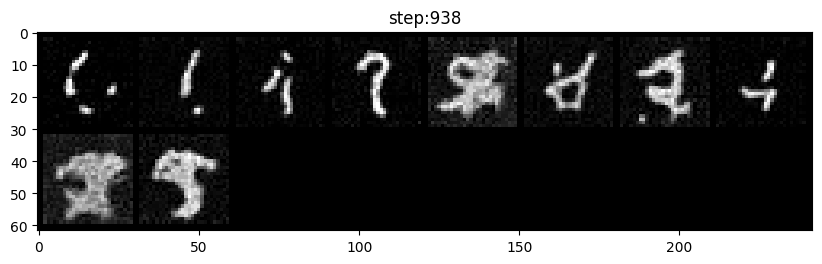

100%|██████████| 1000/1000 [00:01<00:00, 508.79it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.094338894..1.043318].


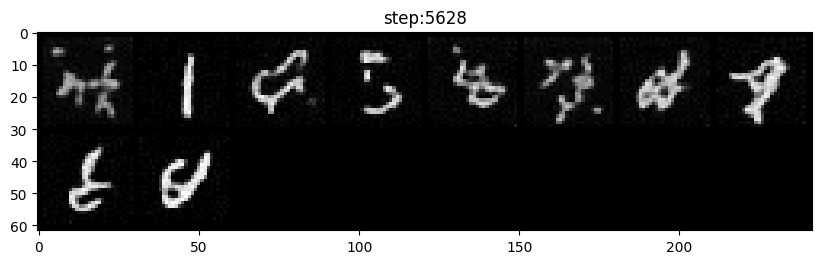

100%|██████████| 1000/1000 [00:01<00:00, 573.79it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07213223..0.993261].


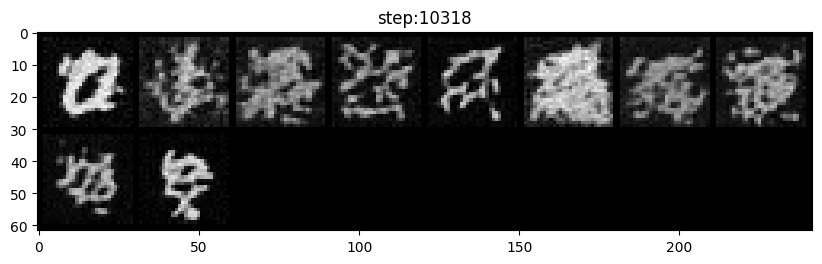

100%|██████████| 1000/1000 [00:01<00:00, 578.55it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.073441625..1.0941474].


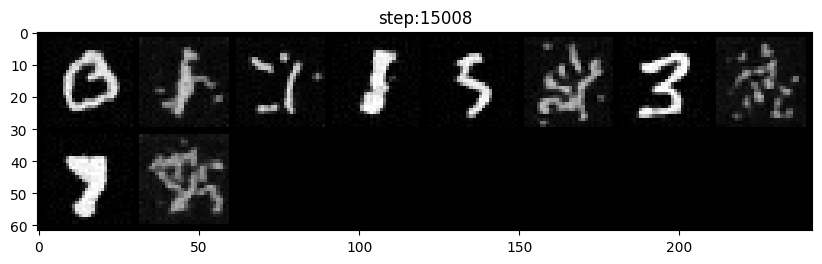

100%|██████████| 1000/1000 [00:01<00:00, 588.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09773123..1.0461112].


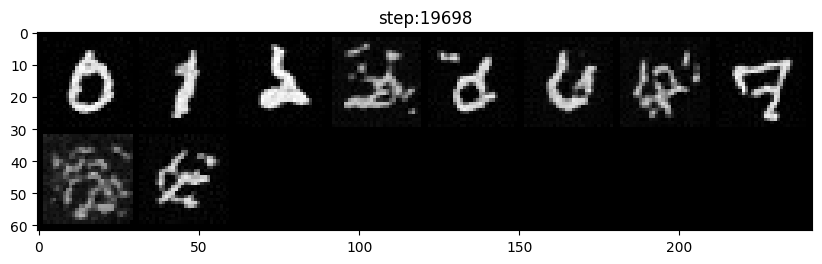

100%|██████████| 1000/1000 [00:01<00:00, 592.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061951995..1.0745261].


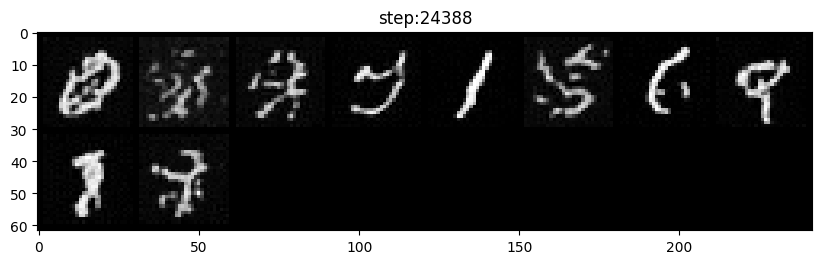

100%|██████████| 1000/1000 [00:01<00:00, 559.17it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.081489384..1.1180599].


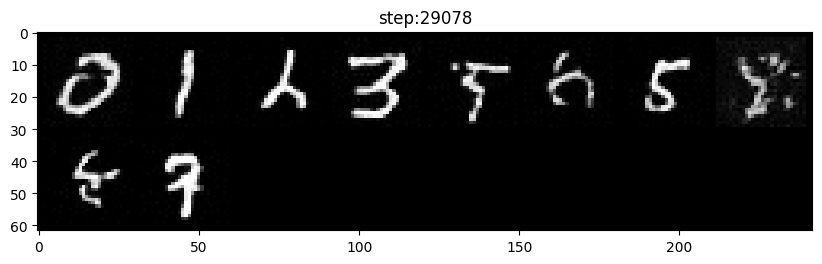

100%|██████████| 1000/1000 [00:01<00:00, 615.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059063256..1.0761347].


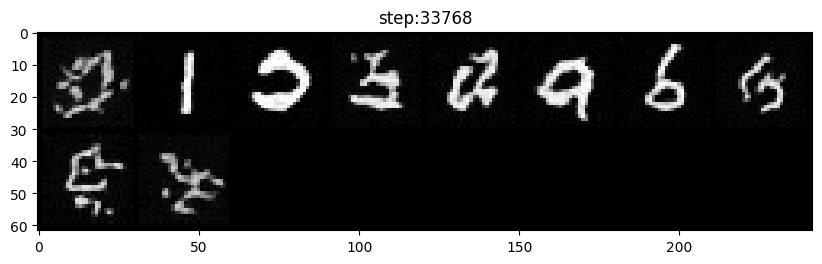

100%|██████████| 1000/1000 [00:01<00:00, 598.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.068192065..1.0859451].


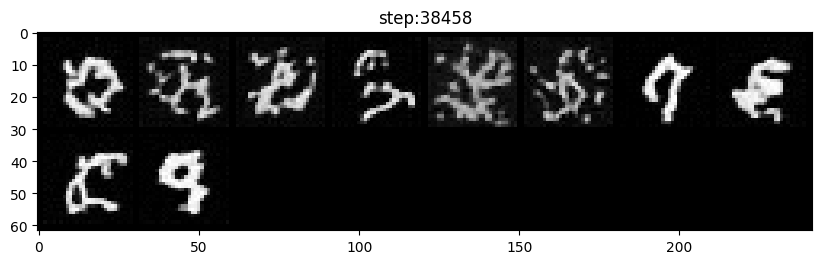

100%|██████████| 1000/1000 [00:01<00:00, 590.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06255764..1.175425].


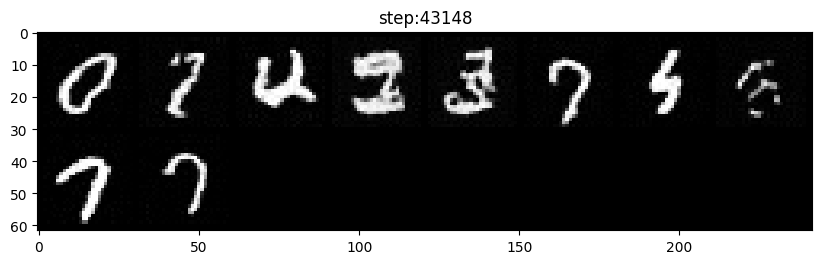

In [20]:
# sample training
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(unet.parameters(),lr=5e-4)

step=0

for epoch in range(50):
    for x,y in tqdm(train_dataloader,total=len(train_dataloader),leave=False):
        
        unet.train()
        
        x = x.to(device)
        
        t = torch.randint(0,T,(x.shape[0],))
        
        noise = torch.randn_like(x).to(device)

        # Forward diffusion
        alpha_bar = alpha_bars[t][:,None,None,None].to(device)
        x_noised = torch.sqrt(alpha_bar)*x + torch.sqrt(1-alpha_bar) * noise

        # Reverse diffusion
        pred_noise = unet(x_noised,t,y)
        
        loss_val = loss_fn(pred_noise,noise)

        loss_val.backward()
       
        optimizer.step()
        optimizer.zero_grad() 
        
        step+=1
        
    if epoch%5==0:
        generate_image()

# Using Hugging Face

## Set Up

In [1]:
import torch
import torch.nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from IPython.display import clear_output
import time
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


c:\Users\Usuario\anaconda3\envs\synthetic\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, ), (0.5, ))
])

dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=transform)

Input shape: torch.Size([64, 1, 28, 28])
Labels: tensor([0, 5, 0, 1, 5, 5, 6, 1, 7, 1, 6, 9, 9, 2, 1, 1, 4, 1, 7, 5, 0, 1, 7, 9,
        1, 1, 1, 2, 2, 6, 2, 7, 4, 5, 0, 6, 7, 4, 3, 6, 1, 1, 7, 9, 6, 1, 5, 1,
        5, 1, 7, 3, 6, 3, 0, 7, 1, 4, 2, 7, 7, 7, 6, 1])


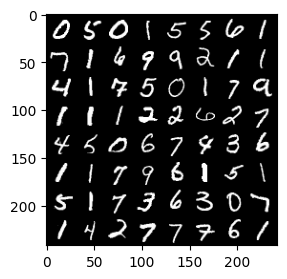

In [3]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)

plt.figure(figsize=(10, 3))
plt.imshow(torchvision.utils.make_grid(x*0.5 + 0.5).permute(1, 2, 0).numpy())
plt.show()

## Use the Diffuser Library

In [4]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
print(scheduler)

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.35.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}



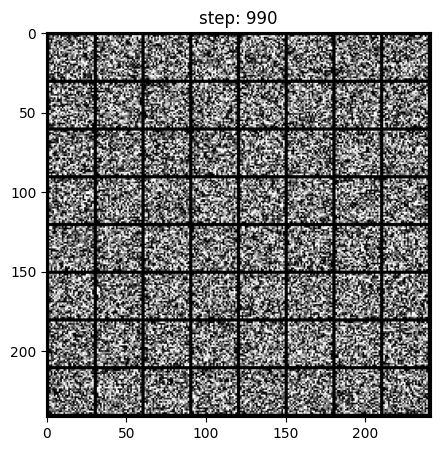

In [5]:
for t in range(scheduler.num_train_timesteps):
    noise = torch.randn_like(x)

    x_noised = scheduler.add_noise(x, noise, torch.tensor(t).long())

    if t%10 == 0:
        plt.figure(figsize=(5, 5))
        plt.title(f"step: {t}")
        plt.imshow(torchvision.utils.make_grid(x_noised*0.5 + 0.5).permute(1, 2, 0).cpu().numpy())
        clear_output(wait=True)
        plt.show()

## The U-Net from the Diffuser Library

In [6]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2, # how many ResNet layers to use per U-Net block
    time_embedding_dim=128,
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    mid_block_type="UNetMidBlock2D",
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    block_out_channels=(32, 32, 64),
    class_embed_type="timestep",
    num_class_embeds=10
)

In [7]:
# count num of parameters in the model
print(f"Number of parameters in the model: {sum(p.numel() for p in unet.parameters())}")

Number of parameters in the model: 1188801


In [9]:
unet.to(device)
x = torch.randn(5, 1, 28, 28).to(device)
t = torch.linspace(0, 999, 5).long().to(device)
cls = torch.randperm(5).long().to(device)

with torch.no_grad():
    output = unet(x, t, cls)

output.sample.shape

torch.Size([5, 1, 28, 28])

In [10]:
def generate_image():
    xt = torch.randn(10, 1, 28, 28).to(device)
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)

    unet.eval()

    for t in tqdm(scheduler.timesteps, total=scheduler.num_train_timesteps, leave=False):
        with torch.no_grad():
            noise_pred = unet(xt, t, y).sample
        
        xt = scheduler.step(noise_pred, t, xt).prev_sample
    
    plt.figure(figsize=(10, 3))
    plt.imshow(torchvision.utils.make_grid(xt*0.5 + 0.5).permute(1, 2, 0).cpu().numpy())
    plt.show()

c:\Users\Usuario\anaconda3\envs\synthetic\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


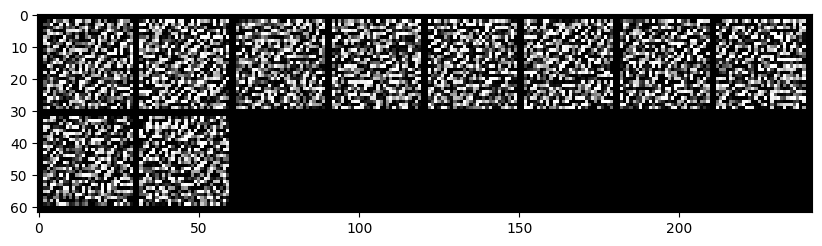

In [11]:
generate_image()

## Train the Diffusion Model

c:\Users\Usuario\anaconda3\envs\synthetic\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


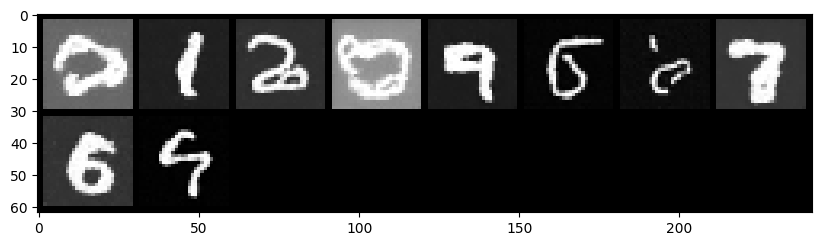

Finished epoch 0. Average of the last 100 loss values: 0.034467


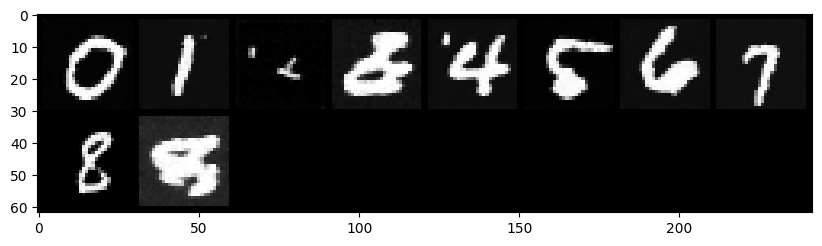

Finished epoch 1. Average of the last 100 loss values: 0.031130


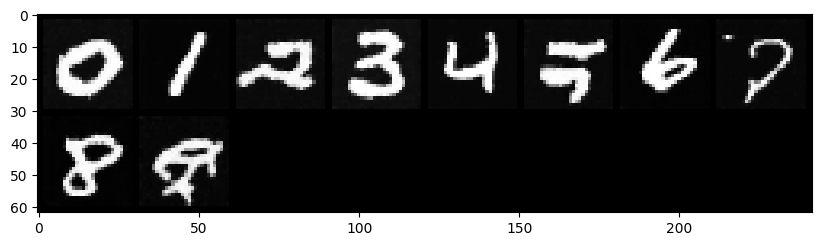

Finished epoch 2. Average of the last 100 loss values: 0.029413


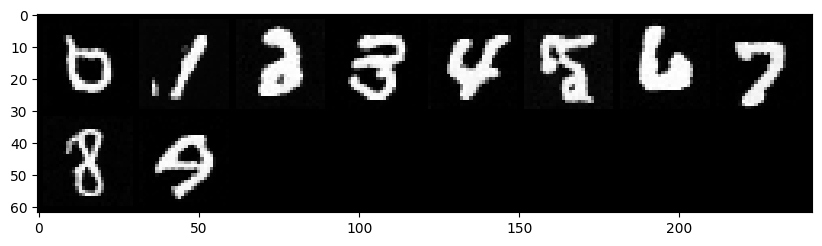

Finished epoch 3. Average of the last 100 loss values: 0.028738


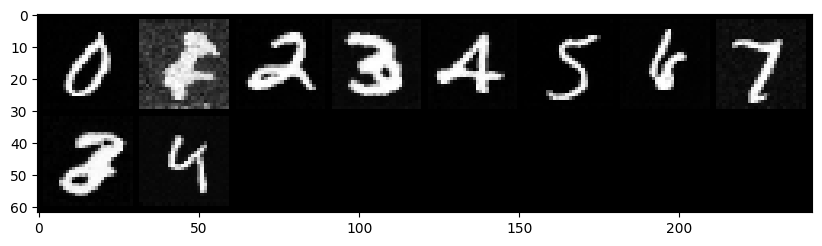

Finished epoch 4. Average of the last 100 loss values: 0.028581


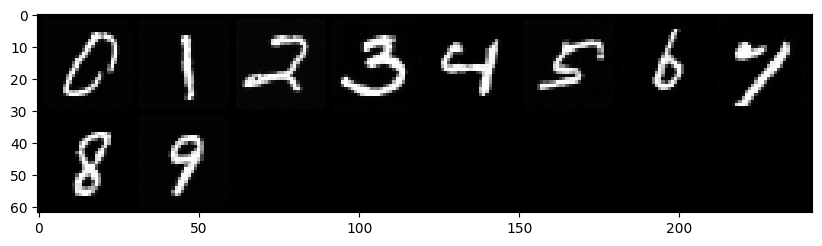

Finished epoch 5. Average of the last 100 loss values: 0.028230


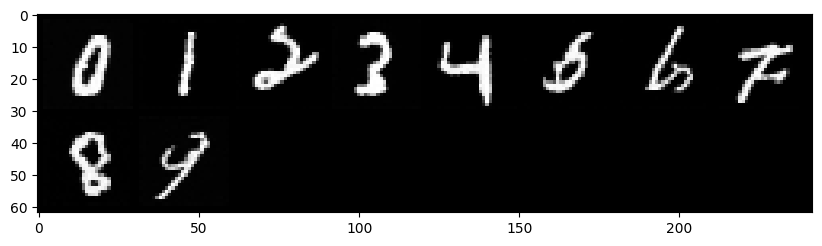

Finished epoch 6. Average of the last 100 loss values: 0.027858


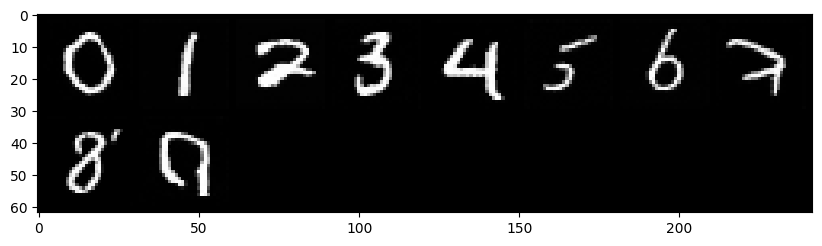

Finished epoch 7. Average of the last 100 loss values: 0.027682


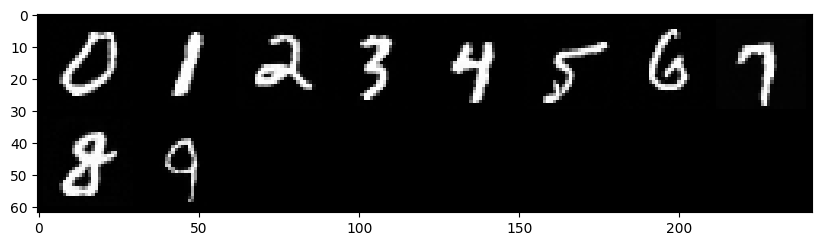

Finished epoch 8. Average of the last 100 loss values: 0.027372


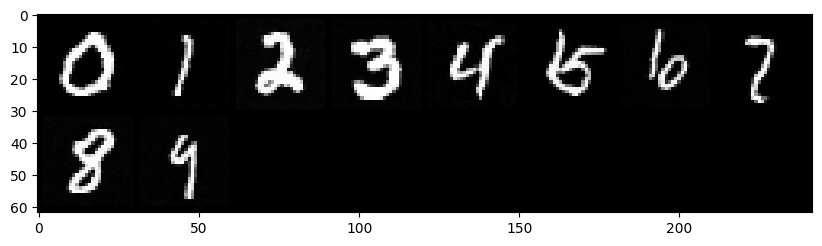

Finished epoch 9. Average of the last 100 loss values: 0.026435


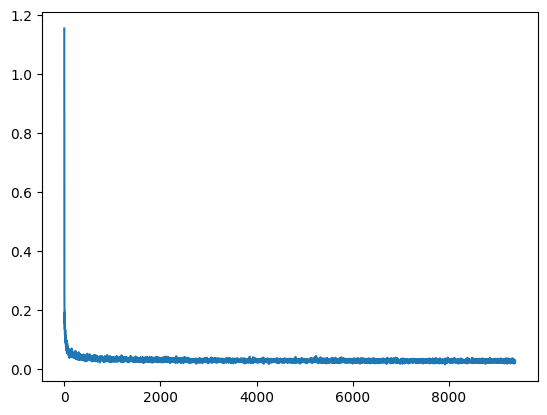

In [13]:
import torch
import torch.nn as nn

n_epochs = 10

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.AdamW(unet.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader,total=len(train_dataloader),leave=False):
        
        # Get some data and prepare the corrupted version
        x = x.to(device) 
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = unet(noisy_x, timesteps, y).sample # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
        
    generate_image()

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

c:\Users\Usuario\anaconda3\envs\synthetic\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 1000/1000 [00:19<00:00, 52.34it/s]


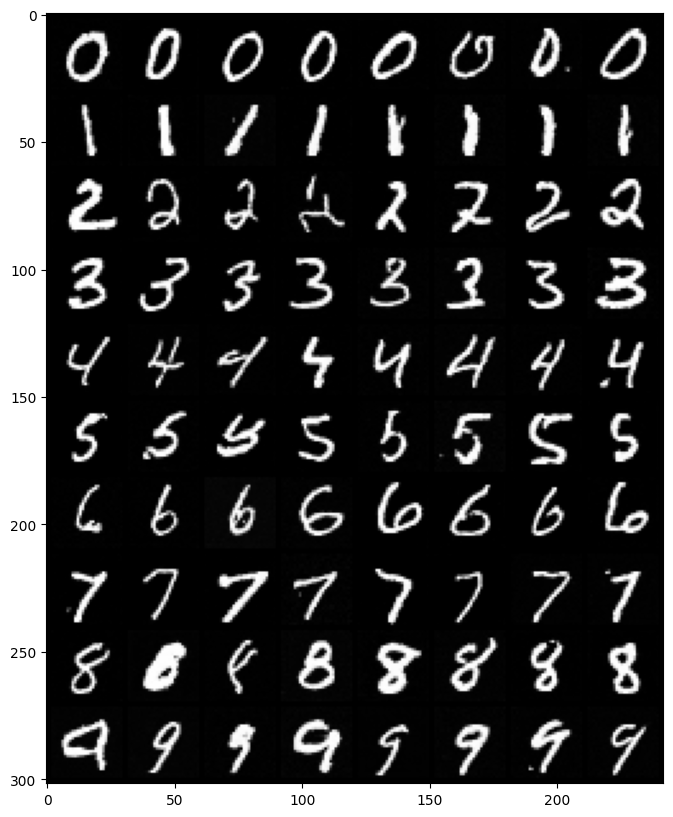

In [14]:
xt = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

unet.eval()

for t in tqdm(scheduler.timesteps, total=scheduler.num_train_timesteps, leave=True):
    with torch.no_grad():
        noise_pred = unet(xt, t, y).sample
    
    xt = scheduler.step(noise_pred, t, xt).prev_sample

plt.figure(figsize=(10, 10))
plt.imshow(torchvision.utils.make_grid(xt*0.5 + 0.5).permute(1, 2, 0).cpu().numpy())
plt.show()